In [254]:
from itertools import accumulate
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2, StatePreparation
from qiskit.quantum_info import SparsePauliOp, Statevector

In [422]:
def get_model(num_sites, J=0.5, hx=0.5, hy=1):
    spo = SparsePauliOp.from_sparse_list(
        [("XX", [i, i + 1], -J) for i in range(num_sites - 1)]
        + [("X", [i], -hx) for i in range(num_sites)]
        + [("Y", [i], -hy) for i in range(num_sites)],
        num_sites,
    )

    return spo

In [432]:
def get_model(num_sites, J=0.25, g=-1):
    spo = SparsePauliOp.from_sparse_list(
        [("XX", [i, (i + 1) % num_sites], J) for i in range(num_sites)]
        + [("YY", [i, (i + 1) % num_sites], J) for i in range(num_sites)]
        + [("ZZ", [i, (i + 1) % num_sites], J) for i in range(num_sites)]
#         + [("X", [i], g) for i in range(num_sites)]
        + [("Z", [i], g) for i in range(num_sites)],
        num_sites,
    )

    return spo

### Distributions

In [423]:
def kron(elements):
    assert elements.shape[-1] == 2 # one qubit states
    if elements.shape[0] == 1:
        return elements
    else:
        return np.kron(kron(elements[:-1,:]), elements[[-1], :])
    
def wrong_ry(n):
    circuit = QuantumCircuit(n)
    random_angles = 2 * np.pi * (np.random.random(n) - 0.5)  # in [-pi, pi]
    for i, angle in enumerate(random_angles):
        circuit.ry(angle, i)
    
    return Statevector(circuit), 1
    
def unif_bloch(n):
    theta = np.random.uniform(0, 2 * np.pi, n)
    v = np.random.uniform(0, 1, n)
    phi = np.arccos(1 - 2 * v)

    circuit = QuantumCircuit(n)
    for i, (theta_i, phi_i) in enumerate(zip(theta, phi)):
        circuit.ry(phi_i, i)
        circuit.rz(theta_i, i)
    
    return Statevector(circuit), 1

def unif_nd(n):
#     vector = np.random.multivariate_normal(mean, sigma)
    vector = np.random.randn(2 ** n)
    return Statevector(vector / np.linalg.norm(vector)), 1

def unif_2d(n):
    if n % 2 != 0:
        raise ValueError("No!")
    vectors = [np.random.randn(4) for _ in range(n // 2)]
    statevec = vectors[0]
    for vector in vectors[1:]:
        statevec = np.kron(statevec, vector)
    return Statevector(statevec / np.linalg.norm(statevec)), 1

def random_basis(n, zero_magn):
    if zero_magn:
        if n % 2 != 0:
            raise ValueError("No!")
        vector = [0] * (n // 2) + [1] * (n // 2)
        vector = np.random.permutation(vector)
    else:
        vector = np.random.randint(0, 2, n)

    labels = "".join(map(str, vector))
    initial = Statevector.from_label(labels)
    return initial, 1

def product_zeromagn(n):
    initial, _ = random_basis(n, zero_magn=True)
    angle = np.random.random(2) * 2 * np.pi
    rot = QuantumCircuit(n)
    rot.rx(angle[0], range(n))
    rot.ry(angle[1], range(n))

    
#     angles = np.random.random(n) * 2 * np.pi
#     for i, angle in enumerate(angles):
#         rot.rx(angle, i)
    return initial.evolve(rot), 1
    
def product(n):
    theta = np.random.uniform(0, np.pi, size=n)
    phi = np.random.uniform(0, np.pi/2, size=n)
    coeff0 = np.cos(theta)
    coeff1 = np.sin(theta)*np.exp(1j*phi)
    coeff = np.stack((coeff0, coeff1), axis=-1)
    initial = kron(coeff).flatten()
    
    return initial, 1

def random_varform(n, reps=3):
    circuit = EfficientSU2(n, reps=reps, entanglement="pairwise")
    values = 2 * np.pi * np.random.random(circuit.num_parameters)
    bound = circuit.bind_parameters(values)
    return Statevector(bound), 1

def gaussian(n):
    xi = np.random.multivariate_normal(mean=np.zeros(4 * n), cov=0.25 * np.identity(4 * n))
    xi = xi.reshape((2 * n, 2)).view(np.complex128)
    xi = xi.reshape((n, 2))
    circuit = QuantumCircuit(n)
    for i, xi_i in enumerate(xi.tolist()):
#         theta = 2 * np.arccos(xi_i[0] / np.linalg.norm(xi_i))
#         circuit.ry(theta, i)
        circuit.prepare_state(xi_i / np.linalg.norm(xi_i), [i])
    
    return Statevector(circuit), 1

def metts(n, real=False):
    if real:
        xi = np.random.normal(size=2 * n)  
    else:
        xi = np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(2 * n, 2)).view(np.complex128)  
        
    pdf = np.pi ** (-2 * n) * np.exp(-np.sum(np.abs(xi) ** 2))

    xi = xi.reshape((n, 2))
    circuit = QuantumCircuit(n)
    for i, xi_i in enumerate(xi.tolist()):
#         theta = 2 * np.arccos(xi_i[0] / np.linalg.norm(xi_i))
#         circuit.ry(theta, i)
        circuit.prepare_state(xi_i / np.linalg.norm(xi_i), [i])
    
    return Statevector(circuit), pdf


### Exact observable value

In [424]:
def exact(n, beta, obs):
    hamiltonian = get_model(num_sites=n)
    H = hamiltonian.to_matrix()
    O = obs.to_matrix()
    
    rho = sc.linalg.expm(-beta * H)
    rho /= np.trace(rho)
    
    return np.trace(O.dot(rho)).real

In [425]:
def correlation(n):
    return SparsePauliOp(["ZZ" + "I" * (n - 2)])

In [426]:
n = 12
corr = correlation(n)
beta = 1

### TPQ states

In [427]:
def tqp(n, beta, obs, sample_initial, num_samples, return_all=False, H=None, O=None):
    hamiltonian = get_model(num_sites=n)
    if H is None:
        H = hamiltonian.to_matrix()
        
    if O is None:
        O = obs.to_matrix()

    U = sc.linalg.expm(-beta / 2 * H)
    
    As, Zs, probs = [], [], []
    for _ in range(num_samples):
        initial, prob = sample_initial(n)
        state = U.dot(initial)
    
        Z = np.conj(state).dot(state)
        A = np.conj(state).dot(O.dot(state)) / Z
        
        As.append(A)
        Zs.append(Z)
        probs.append(prob)
        
        
    average = np.sum([A_i * Z_i * p_i for A_i, Z_i, p_i in zip(As, Zs, probs)]) / np.sum([Z_i * p_i for Z_i, p_i in zip(Zs, probs)])
    if return_all:
        return average, As, Zs
    
    return average

In [173]:
n = 6
sz = SparsePauliOp.from_sparse_list([("Z", [i], 1) for i in range(n)], n)
product_zeromagn(n)[0].expectation_value(sz)

(-1.1102230246251565e-16+0j)

In [174]:
exact(n, beta, correlation(n))

-0.05867466060823577

In [176]:
hamiltonian = get_model(num_sites=n)
H = hamiltonian.to_matrix(sparse=True)
O = correlation(n).to_matrix(sparse=True)

In [180]:
n = 6
vals = [tqp(n, beta, hamiltonian, unif_nd, 10) for _ in range(100)]

In [181]:
np.mean(vals), np.std(vals)

((-6.630175292881397+1.4336582948806482e-18j), 0.22365874161034743)

#### METTS

In [245]:
ansatz = EfficientSU2(2, reps=1)

In [377]:
def qm(hamiltonian, beta, observables, num_samples, *args, **kwargs):
    samples = []
    vector = np.random.randint(0, 2, n)
    bitstring = "".join(map(str, vector))
#     bitstring = "".join(map(lambda bit: "+" if bit == "0" else "-", vector))
    initial_state = StatePreparation(bitstring)

    # we append the initial state to the circuit and start from 0 parameters
    # alternatively, the last layer of the circuit could be tuned to prepare the initial state
    initial_parameters = np.zeros(ansatz.num_parameters)

    hadamards = QuantumCircuit(ansatz.num_qubits)
    hadamards.h(hadamards.qubits)

    H = hamiltonian.to_matrix(sparse=True)
    U = sc.sparse.linalg.expm(-beta / 2 * H)
    O = [obs.to_matrix(sparse=True) for obs in observables]

    samples = []
    bitstrings = [bitstring]
    evolver_results = []
    for i in range(num_samples):
        model = ansatz.compose(initial_state)
#         print("Initial", bitstring)

        # reference values
        exact_state = U.dot(Statevector(model.bind_parameters(initial_parameters)))
        norm = np.conj(exact_state).dot(exact_state)
        reference_samples = [np.conj(exact_state).dot(obs.dot(exact_state)) / norm for obs in O]
        samples.append(reference_samples)

        # stop here if no more samples are drawn
        if i == num_samples - 2:
            break
            
        exact_state = Statevector(exact_state / np.sqrt(norm))

        # switch basis
        if i % 2 == 0:
            exact_state.evolve(hadamards)
#             model.compose(hadamards, model.qubits, inplace=True)

        # sample new product state
        bitstring, _ = exact_state.measure()

        if i % 2 == 0:
#             print("pre", bitstring)
            bitstring = "".join(map(lambda bit: "+" if bit == "0" else "-", bitstring))
#             print("post", bitstring)
        bitstrings.append(bitstring)

        initial_state = StatePreparation(bitstring)
        
    return np.mean(samples), samples, bitstrings

In [378]:
n = 2
beta = 1
# obs = correlation(n)
obs = get_model(n)
print("beta:", beta)
print("expect:", exact(n, beta, obs))

beta: 1
expect: -1.3403022892453023


In [379]:
num_samples = 10
avgs = []
bits = []

for _ in range(10):
    avg, samples, bitstrings = qm(obs, beta, [obs], num_samples=num_samples)
#     print(dict(zip(bitstrings, samples)))
    bits += bitstrings
    avgs.append(avg)

#     plt.hist(np.real(As))
#     print(As)

print("Mean and std:", np.mean(avgs), np.std(avgs))

Mean and std: (-1.1769247591512895+0j) 0.22591011201020358


{'00': 25, '01': 10, '10': 12, '11': 3, '++': 22, '+-': 9, '-+': 7, '--': 2}


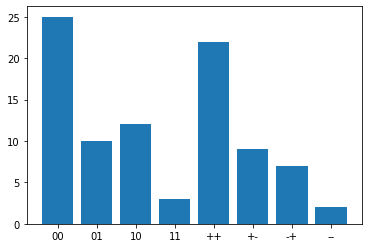

In [380]:
freq = {state: 0 for state in ["00", "01", "10", "11", "++", "+-", "-+", "--"]}
for state in bits:
    freq[state] += 1
    
x = np.arange(8)
plt.bar(x, freq.values())
plt.xticks(x, freq.keys())
print(freq)

In [433]:
def qmetts(n, beta, obs, num_samples, return_all=False, U=None, O=None):
    hamiltonian = get_model(num_sites=n)
    if O is None:
        O = obs.to_matrix()
        
    if U is None:
        H = hamiltonian.to_matrix()
        U = sc.linalg.expm(-beta / 2 * H)
    
    As, Zs = [], []
    initial, _ = random_basis(n, zero_magn=False)
#     hadamard_on = [i for i in range(n) if np.random.random() > 0.5]
    hadamards = QuantumCircuit(n)
    hadamards.h(range(n))
#     if len(hadamard_on) > 0:
#         hadamards.h(hadamard_on)
    
#     initial = initial.evolve(hadamards)
    
    for i in range(num_samples):
        # evolve
#         print("initial state:", initial)
        state = U.dot(initial)
    
        # normalize
        Z = np.conj(state).dot(state)
        state = state / np.sqrt(Z)
        
        # evaluate 
        A = np.conj(state).dot(O.dot(state))
        
        As.append(A)
        Zs.append(Z)
        
        state = Statevector(state)
        
        if i % 2 != 0:
            label, new_state = state.measure()
            initial = Statevector.from_label(label)
#             print(label)
        else:
#         if True:
#             hadamard_on = [i for i in range(n) if np.random.random() > 0.5]
            hadamards = QuantumCircuit(n)
            hadamards.h(range(n))
#             if len(hadamard_on) > 0:
#                 hadamards.h(hadamard_on)
            label, new_state = state.evolve(hadamards).measure()
            initial = Statevector.from_label(label)
            initial = initial.evolve(hadamards)
             

        pr = np.conj(new_state).dot(state)
            
    average = np.mean(As)
    if return_all:
        return average, As, Zs, U, O
    
    return average

In [434]:
n = 12
beta = 1
# obs = correlation(n)
obs = get_model(n)
print("beta:", beta)
print("expect:", exact(n, beta, obs))

beta: 1
expect: -7.0116753367530835


In [435]:
samples = 50
avg, As, _, U, O = qmetts(n, beta, obs, num_samples=samples, return_all=True)
print(avg, np.mean(As[-50:]))
avgs= [avg]

for _ in range(9):
    avg, As, _, _, _ = qmetts(n, beta, obs, num_samples=samples, return_all=True, U=U, O=O)
    print(avg, np.mean(As[-50:]))
    avgs.append(avg)

#     plt.hist(np.real(As))
#     print(As)

print("Mean and std:", np.mean(avgs), np.std(avgs))

(-6.849107103473715+0j) (-6.849107103473715+0j)
(-6.719190554822623+0j) (-6.719190554822623+0j)
(-6.991598743472765+0j) (-6.991598743472765+0j)
(-6.901104380338892+0j) (-6.901104380338892+0j)
(-6.952827225132307+0j) (-6.952827225132307+0j)
(-6.819755699956625+0j) (-6.819755699956625+0j)
(-6.994923457121596+0j) (-6.994923457121596+0j)
(-7.05886446099592+0j) (-7.05886446099592+0j)
(-6.724038378683497+0j) (-6.724038378683497+0j)
(-7.183239969719535+0j) (-7.183239969719535+0j)
Mean and std: (-6.9194649973717475+0j) 0.13948134152072564


In [436]:
samples = 50
avg, As, _, U, O = qmetts(n, beta, obs, num_samples=samples, return_all=True)
print(avg, np.mean(As[-50:]))
avgs= [avg]

for _ in range(9):
    avg, As, _, _, _ = qmetts(n, beta, obs, num_samples=samples, return_all=True, U=U, O=O)
    print(avg, np.mean(As[-50:]))
    avgs.append(avg)

#     plt.hist(np.real(As))
#     print(As)

print("Mean and std:", np.mean(avgs), np.std(avgs))

(-6.499767458464952+0j) (-6.499767458464952+0j)
(-7.083534831831558+0j) (-7.083534831831558+0j)
(-6.756651462367256+0j) (-6.756651462367256+0j)
(-6.929467194083807+0j) (-6.929467194083807+0j)
(-6.92301907341493+0j) (-6.92301907341493+0j)
(-7.00239093668151+0j) (-7.00239093668151+0j)
(-7.0875377348583255+0j) (-7.0875377348583255+0j)
(-6.872802934131422+0j) (-6.872802934131422+0j)
(-6.860399488029389+0j) (-6.860399488029389+0j)
(-6.752392898386465+0j) (-6.752392898386465+0j)
Mean and std: (-6.876796401224961+0j) 0.16738700416838365


In [431]:
samples = 50
avg, As, _, U, O = qmetts(n, beta, obs, num_samples=samples, return_all=True)
print(avg, np.mean(As[-50:]))
avgs= [avg]

for _ in range(9):
    avg, As, _, _, _ = qmetts(n, beta, obs, num_samples=samples, return_all=True, U=U, O=O)
    print(avg, np.mean(As[-50:]))
    avgs.append(avg)

#     plt.hist(np.real(As))
#     print(As)

print("Mean and std:", np.mean(avgs), np.std(avgs))

(-13.49889970893065-3.694961003830599e-18j) (-13.49889970893065-3.694961003830599e-18j)
(-13.670619851089715+8.777700788442645e-18j) (-13.670619851089715+8.777700788442645e-18j)
(-13.516454542661064-1.807581861967833e-17j) (-13.516454542661064-1.807581861967833e-17j)
(-13.863055490635926+6.87817858224804e-17j) (-13.863055490635926+6.87817858224804e-17j)
(-13.597451954885365-9.662409761190816e-17j) (-13.597451954885365-9.662409761190816e-17j)
(-13.759106077915835-4.9404924595819467e-17j) (-13.759106077915835-4.9404924595819467e-17j)
(-13.610370160840677+9.39352762241441e-17j) (-13.610370160840677+9.39352762241441e-17j)
(-13.766210833085127+2.1094237467877975e-17j) (-13.766210833085127+2.1094237467877975e-17j)
(-13.742198507337962+3.918740332231607e-17j) (-13.742198507337962+3.918740332231607e-17j)
(-13.662040131461767-6.245004513516506e-18j) (-13.662040131461767-6.245004513516506e-18j)
Mean and std: (-13.66864072588441+5.773159728050813e-18j) 0.11017948336866162


In [430]:
samples = 50
avg, As, _, U, O = qmetts(n, beta, obs, num_samples=samples, return_all=True)
print(avg, np.mean(As[-50:]))
avgs= [avg]

for _ in range(9):
    avg, As, _, _, _ = qmetts(n, beta, obs, num_samples=samples, return_all=True, U=U, O=O)
    print(avg, np.mean(As[-50:]))
    avgs.append(avg)

#     plt.hist(np.real(As))
#     print(As)

print("Mean and std:", np.mean(avgs), np.std(avgs))

(-13.827593004156995+2.9039270987851754e-17j) (-13.827593004156995+2.9039270987851754e-17j)
(-13.533030423662222-1.5612511283791264e-17j) (-13.533030423662222-1.5612511283791264e-17j)
(-13.617217625307024-5.714179129867602e-17j) (-13.617217625307024-5.714179129867602e-17j)
(-13.515900783640381-6.04724603725515e-17j) (-13.515900783640381-6.04724603725515e-17j)
(-13.646604204193277-4.073130721593543e-17j) (-13.646604204193277-4.073130721593543e-17j)
(-13.83637273303881-1.7694179454963434e-17j) (-13.83637273303881-1.7694179454963434e-17j)
(-13.585098772756654-2.931682674400804e-18j) (-13.585098772756654-2.931682674400804e-18j)
(-13.833295613832375+2.789435349370706e-17j) (-13.833295613832375+2.789435349370706e-17j)
(-13.776768839778953+6.399394902878441e-17j) (-13.776768839778953+6.399394902878441e-17j)
(-13.608734241623086+2.1527918336872176e-17j) (-13.608734241623086+2.1527918336872176e-17j)
Mean and std: (-13.678061624198978-5.212844045310304e-18j) 0.12113334522615715


In [185]:
samples = 100
avg, As, _, U, O = qmetts(n, beta, obs, num_samples=samples, return_all=True)
print(avg, np.mean(As[-50:]))
avgs = [avg]

for _ in range(10):
    avg, As, _, _, _ = qmetts(n, beta, obs, num_samples=samples, return_all=True, U=U, O=O)
    print(avg, np.mean(As[-50:]))
    avgs.append(avg)

#     plt.hist(np.real(As))
#     print(As)

print("Mean and std:", np.mean(avgs), np.std(avgs))

(-13.655070057573008+1.2195106036116954e-17j) (-13.722655516408473+1.762479051592436e-17j)
(-13.653838993209638+1.1986939218999737e-17j) (-13.677307468837313+2.84147705365001e-17j)
(-13.689887266528013+1.3444106938820255e-17j) (-13.743334796901877+9.627715291671279e-18j)
(-13.636225664484991-1.8761034392689168e-17j) (-13.640827118735467+1.1744077932362985e-17j)
(-13.714504840325672-5.100087019371813e-18j) (-13.684386028649062+1.2906342661267445e-17j)
(-13.57880812304687-9.324138683375338e-18j) (-13.557998783754165-5.197231534026514e-17j)
(-13.718270381026041+1.4276774207289123e-17j) (-13.790620010647046+4.3853809472693685e-17j)
(-13.633282988236957-1.397319759899318e-17j) (-13.647050513861455+8.656270145124268e-18j)
(-13.63678244529384-9.107298248878238e-19j) (-13.741502188436122+3.6845526629747386e-17j)
(-13.591344398252273+6.295311494319833e-17j) (-13.679949536829382+1.0099560077136971e-16j)
(-13.568974348603524-3.300311413045876e-17j) (-13.541963029686658-6.690828446842545e-17j)
Mea

In [139]:
samples = 100
avg, As, _, U, O = qmetts(n, beta, obs, num_samples=samples, return_all=True)
print(avg, np.mean(As[-50:]))

for _ in range(10):
    avg, As, _, _, _ = qmetts(n, beta, obs, num_samples=samples, return_all=True, U=U, O=O)
    print(avg, np.mean(As[-50:]))

#     plt.hist(np.real(As))
#     print(As)

(0.5318638990912785+0j) (0.5574985523799212+0j)
(0.4108759800042405+0j) (0.4238309253682639+0j)
(0.5405275690661683+0j) (0.5319410004275236+0j)
(0.3899188206121662+0j) (0.2984692967771036+0j)
(0.41958334518178947+0j) (0.4319858623859683+0j)
(0.500666542545477+0j) (0.4843308111179838+0j)
(0.5138674867695382+0j) (0.541160584887785+0j)
(0.48775076686257635+0j) (0.4763383762739061+0j)
(0.4063151029344211+0j) (0.43427783857865165+0j)
(0.4888344187586698+0j) (0.5593501805832395+0j)
(0.48924651702954036+0j) (0.5518852468223914+0j)


### Convergence in system size

In [384]:
def sample(n, beta, obs, sample_initial, nums_samples, runs=50):
    exps = {num_samples: [] for num_samples in nums_samples}
    
    for _ in range(runs):
        _, As, Zs = tqp(n, beta, obs, sample_initial, nums_samples[-1], return_all=True)
        for num_samples in nums_samples:
            exp = np.sum([A_i * Z_i for A_i, Z_i in zip(As[:num_samples], Zs[:num_samples])]) / np.sum(Zs[:num_samples])
            exps[num_samples].append(exp)
            
    return exps

In [697]:
nums_samples = [10, 20, 50, 100, 200, 500]
n = [3, 5, 8, 10]

In [387]:
uniform_nd = {
    n_i: sample(n_i, beta, correlation(n_i), unif_nd, nums_samples) for n_i in n
}

In [388]:
rand_ansatz = {
    n_i: sample(n_i, beta, correlation(n_i), random_varform, nums_samples) for n_i in n
}

In [698]:
rand_ansatz_r1 = {
    n_i: sample(n_i, beta, correlation(n_i), lambda x: random_varform(x, reps=1), nums_samples) for n_i in n
}

In [702]:
rand_ansatz_r10 = {
    n_i: sample(n_i, beta, correlation(n_i), lambda x: random_varform(x, reps=10), nums_samples) for n_i in n
}

In [294]:
unif_basis = {
    n_i: sample(n_i, beta, correlation(n_i), random_basis, nums_samples) for n_i in n
}

In [343]:
unif_tensored = {
    n_i: sample(n_i, beta, correlation(n_i), unif_bloch, nums_samples) for n_i in n
}

In [393]:
metts_dist = {
    n_i: sample(n_i, beta, correlation(n_i), metts, nums_samples) for n_i in n
}

In [404]:
metts_real_dist = {
    n_i: sample(n_i, beta, correlation(n_i), lambda x: metts(x, real=True), nums_samples) for n_i in n
}

In [307]:
def plot_values(data, color, label):
    ls = ["-", "-.", "--", ":"]
    for i, (n_i, exps_i) in enumerate(data.items()):
        plt.errorbar(exps_i.keys(), 
                     [np.mean(vals) for vals in exps_i.values()], 
                     yerr=[np.std(vals) for vals in exps_i.values()],
                     ls=ls[i],
                     color=color,
                     label=f"{label}, n = {n_i}",
                     capsize=2)

In [309]:
def plot_stds(data, color, label):
    ls = ["-", "-.", "--", ":"]
    for i, (n_i, exps_i) in enumerate(data.items()):
        plt.plot(exps_i.keys(), 
                 [np.std(vals) for vals in exps_i.values()],
                 ls=ls[i],
                 color=color,
                 label=f"{label}, n = {n_i}")

In [341]:
def plot_errors(data, color, label):
    ls = ["-", "-.", "--", ":"]
    for i, (n_i, exps_i) in enumerate(data.items()):
        reference = exact(n_i, beta, correlation(n_i))
        errors = {num_samples: np.abs([reference - np.asarray(values, dtype=float)]) for num_samples, values in exps_i.items()}
        plt.errorbar(errors.keys(),
                     [np.mean(vals) for vals in errors.values()],
                     yerr=[np.std(vals) for vals in errors.values()],
                     marker="o", ls=ls[i], color=color, label=f"{label}, n = {n_i}")

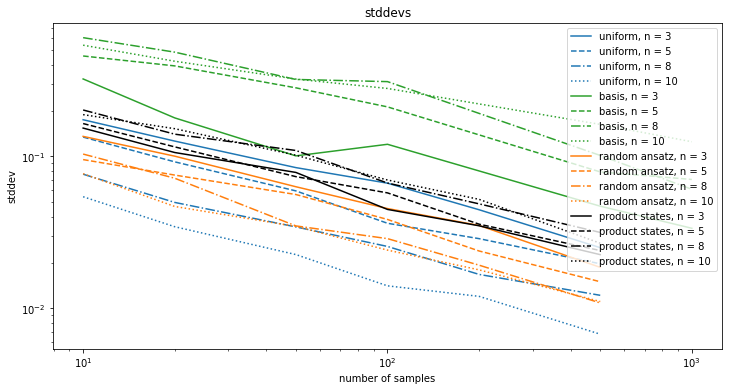

In [591]:
plt.figure(figsize=(12, 6))
plt.title("stddevs")
plt.loglog()
plot_stds(uniform_nd, "tab:blue", "uniform")
plot_stds(unif_basis, "tab:green", "basis")
# plot_stds(unif_tensored, "tab:red", "tensored")
plot_stds(rand_ansatz, "tab:orange", "random ansatz")
plot_stds(metts_dist, "k", "product states")
# plot_stds(metts_real_dist, "grey", "METTS real")
plt.xlabel("number of samples")
plt.ylabel("stddev")
plt.legend(loc="upper right")

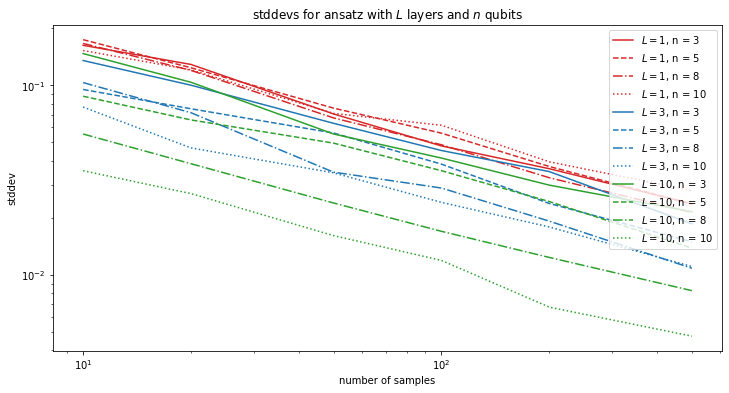

In [706]:
plt.figure(figsize=(12, 6))
plt.title("stddevs for ansatz with $L$ layers and $n$ qubits")
plt.loglog()
plot_stds(rand_ansatz_r1, "tab:red", "$L=1$")
plot_stds(rand_ansatz, "tab:blue", "$L=3$")
plot_stds(rand_ansatz_r10, "tab:green", "$L=10$")
# plot_stds(uniform_nd, "k", "uniform")
plt.xlabel("number of samples")
plt.ylabel("stddev")
plt.legend(loc="upper right")

<ipython-input-341-0e0185a1e630>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  errors = {num_samples: np.abs([reference - np.asarray(values, dtype=float)]) for num_samples, values in exps_i.items()}


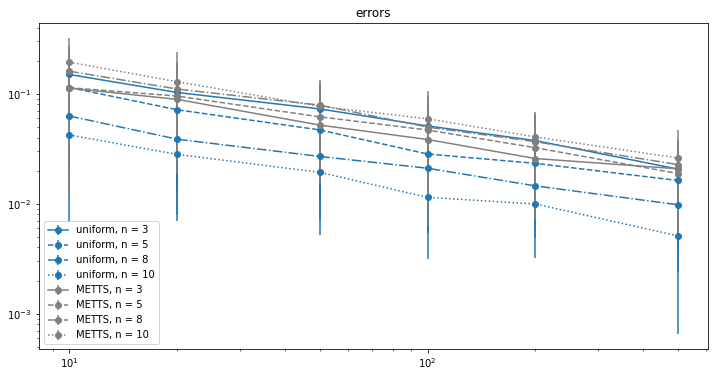

In [391]:
plt.figure(figsize=(12, 6))
plt.title("errors")
plt.loglog()
plot_errors(uniform_nd, "tab:blue", "uniform")
# plot_errors(unif_basis, "tab:green", "basis")
# plot_errors(unif_tensored, "tab:red", "tensored")
# plot_errors(rand_ansatz, "tab:orange", "random ansatz")
plot_errors(metts_dist, "grey", "METTS")
plt.legend(loc="best")

/Users/jul/opt/miniconda3/envs/py10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jul/opt/miniconda3/envs/py10/lib/python3.10/site-packages/numpy/ma/core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


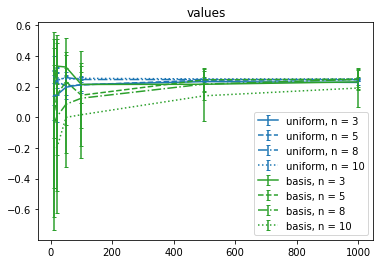

In [338]:
plt.title("values")
plot_values(unif_nd, "tab:blue", "uniform")
plot_values(unif_basis, "tab:green", "basis")
plt.legend(loc="best")

In [191]:
eps = 0.01
d = 100
n = 12

In [194]:
np.log(eps/d) / np.log(11/12)

105.85213900331551

In [193]:
(11/12) 

0.9166666666666666